# Notebook for Part 2

This notebook contains the script and analysis for part 2 of the assessment 3. This takes the pre-processed data (i.e. output from the "UK Weather Data Preprocessing Script" notebook and conducts the relevant pre-processing and analysis relevant for part 2 of assessment 3.

In [1]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [2]:
# Load the data
proc_data_path = '..\proc_data\weather'
weather_df = pd.read_csv(os.path.join(proc_data_path,'weather.csv'))

# Pre-processing Data

Prepare the data set according so that we can do classification

Create the labels Northern Third of the UK, Central Third of the UK and Southern Third of the UK using the latitude ranges provided

In [3]:
def classify_lat(lat):
    '''
    This function takes in a lat variable and splits equally in the range of 49.9 and 60.9
    lat(float): latitude
    '''
    lat_range = 60.9 - 49.9
    lat_segment_len = lat_range/3
    
    if lat <= (49.9 + lat_segment_len):
        region_class = 'Southern Third of the UK'
    elif lat <= (49.9 + 2* lat_segment_len):
        region_class = 'Central Third of the UK'
    elif lat <= 60.9:
        region_class = 'Northern Third of the UK'
    else:
        region_class = None
        
    return region_class

In [4]:
# For simplicity, I will classify according to lat and assign to a column called label
weather_df['label'] = weather_df['lat'].apply(classify_lat)

In [5]:
station_label_mapping = weather_df[['station','label']].drop_duplicates().reset_index(drop = True)
station_label_mapping

,station,label
0,aberporth,Southern Third of the UK
1,armagh,Central Third of the UK
2,ballypatrick,Central Third of the UK
3,bradford,Central Third of the UK
4,braemar,Central Third of the UK
5,camborne,Southern Third of the UK
6,cambridge,Southern Third of the UK
7,cardiff,Southern Third of the UK
8,chivenor,Southern Third of the UK
9,cwmystwyth,Southern Third of the UK


Aggregate the data by taking means

In [6]:
agg_df = weather_df.groupby('station')[['tmax degC','tmin degC','af days','rain mm','sun hours']].mean()
agg_df = agg_df.reset_index()
agg_df.head()

,station,tmax degC,tmin degC,af days,rain mm,sun hours
0,aberporth,12.446138,7.218297,1.535668,76.347975,129.096523
1,armagh,12.946581,5.665598,3.299679,68.810406,103.913016
2,ballypatrick,11.374561,5.534897,2.640063,110.254522,106.663636
3,bradford,12.294444,5.720074,3.753333,72.914059,104.131172
4,braemar,10.515747,2.749529,8.687752,75.632083,98.446739


Exclude 5 of the weather stations from this set by picking the 5 last stations alphabetically

In [7]:
# Sort the station names
station_names = np.sort(agg_df['station'].unique())
print('No. of stations in total: {}'.format(len(station_names)))

# Exclude last five stations
selected_station_names= station_names[:-5]
print('No. of stations in selected: {}'.format(len(selected_station_names)))

No. of stations in total: 37
No. of stations in selected: 32


In [8]:
# Merge with label
agg_df = agg_df.merge(station_label_mapping, how='left', on = 'station')

In [9]:
agg_df_train = agg_df[agg_df['station'].isin(selected_station_names)]
agg_df_test = agg_df[~agg_df['station'].isin(selected_station_names)]

In [10]:
# Get X and y
X_train = agg_df_train.drop(columns = ['station','label'])
y_train = agg_df_train['label']

X_test = agg_df_test.drop(columns = ['station','label'])
y_test = agg_df_test['label']

## Exploratory Data Analysis

* Find the summary statistics of the features
* Data Visualisation

In [11]:
# Mean of weather data for each label
agg_df_train.groupby('label')[['tmax degC','tmin degC','af days','rain mm','sun hours']].mean()

,tmax degC,tmin degC,af days,rain mm,sun hours
label,,,,,
Central Third of the UK,11.967322,5.171508,4.283276,90.251017,107.257543
Northern Third of the UK,10.813210,5.109301,3.455652,83.298134,99.494379
Southern Third of the UK,13.705958,6.652223,3.112168,69.178870,127.768973


In [12]:
# Standard Deviation of weather data for each label
agg_df_train.groupby('label')[['tmax degC','tmin degC','af days','rain mm','sun hours']].std()

,tmax degC,tmin degC,af days,rain mm,sun hours
label,,,,,
Central Third of the UK,0.759036,1.200567,2.187286,29.274847,8.081981
Northern Third of the UK,1.242689,0.232345,0.874978,26.409641,9.422134
Southern Third of the UK,0.849735,0.949224,1.249973,24.505074,14.003530


In [13]:
# Coefficient of variation of weather data for each label
agg_df_train.groupby('label')[['tmax degC','tmin degC','af days','rain mm','sun hours']].std()/agg_df_train.groupby('label')[['tmax degC','tmin degC','af days','rain mm','sun hours']].mean()

,tmax degC,tmin degC,af days,rain mm,sun hours
label,,,,,
Central Third of the UK,0.063426,0.232150,0.510657,0.324371,0.075351
Northern Third of the UK,0.114923,0.045475,0.253202,0.317050,0.094700
Southern Third of the UK,0.061998,0.142693,0.401640,0.354228,0.109600


In [14]:
# Checking the minimum
agg_df_train.groupby('label')[['tmax degC','tmin degC','af days','rain mm','sun hours']].min()

,tmax degC,tmin degC,af days,rain mm,sun hours
label,,,,,
Central Third of the UK,10.515747,2.749529,1.140221,54.506313,97.345619
Northern Third of the UK,9.485701,4.905283,2.771364,52.872744,89.394557
Southern Third of the UK,11.642314,4.886000,0.759295,46.328907,97.186254


In [15]:
# Checking the maximum
agg_df_train.groupby('label')[['tmax degC','tmin degC','af days','rain mm','sun hours']].max()

,tmax degC,tmin degC,af days,rain mm,sun hours
label,,,,,
Central Third of the UK,12.946581,6.758856,8.687752,140.530981,123.825162
Northern Third of the UK,11.948732,5.362196,4.441534,100.297120,108.047403
Southern Third of the UK,14.920364,8.375342,5.113523,149.432712,155.036412


It seems like there is quite a bit of distinction between weather data for each of the labels in terms of the mean. The coefficient of variation indicates that within each of the labels the standard deviation of the weather data relative to the mean is still quite contained.

From the mean for each labels, it seems that Northern Third of UK tends to be the coldest, followed by Central Third of UK and Southern Third of UK. There are most number of AF days in Central Third of UK, and relatively similar number of AF days for Northern Third of UK and Souther Third of UK. More rain in Central Third of UK followed by Northern Third of UK and Southern Third of UK. Most sun hours in Southern Third of UK followed by Central Third of UK and Northern Third of UK.

#### Data Visualisation

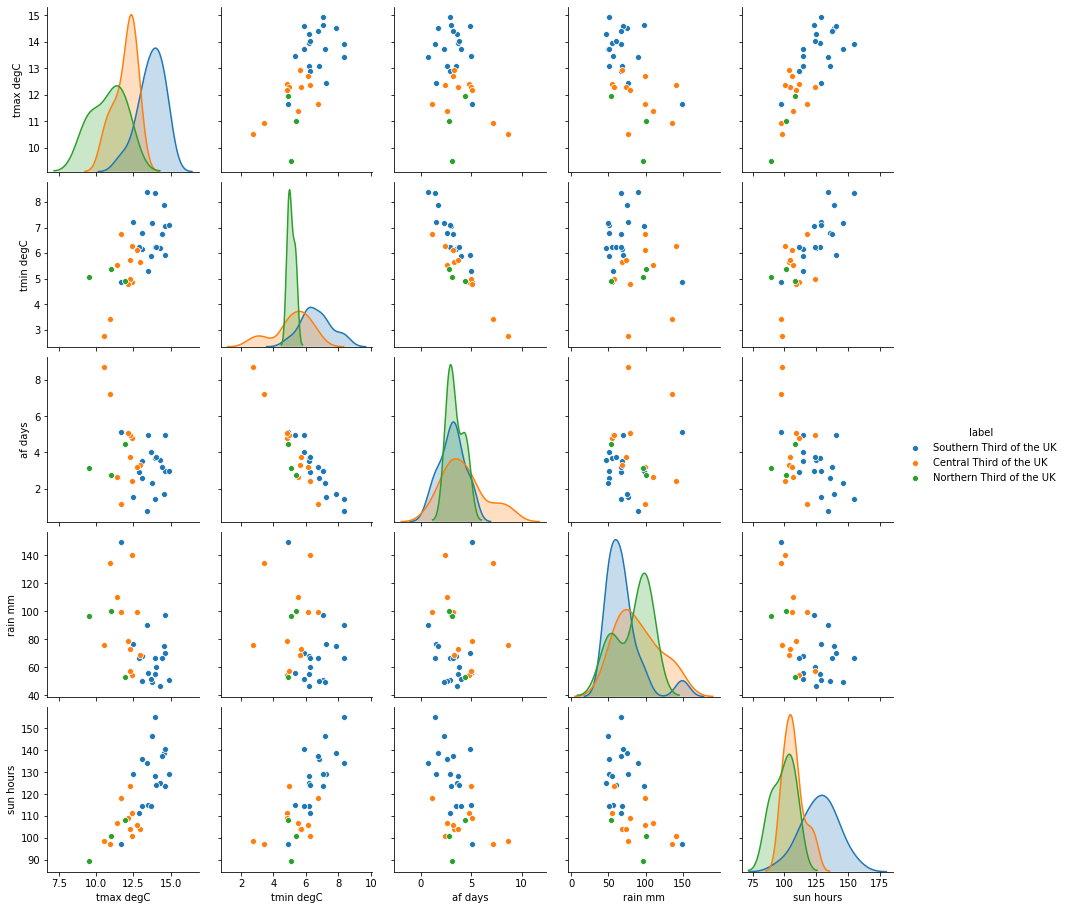

In [16]:
# Check the pair plots
sns.pairplot(agg_df_train, hue = 'label')
plt.show()

From the pair plots, there appears to be some linear relationship between some of the variables:
* tmax and tmin (positive)
* tmax and rain (negative)
* tmax and sun hours (positive)
* tmin and af days (negative)
* tmin and rain (positive)
* tmin and sun hours (positive)
* af days and sun hours (negative)
* rain and sun hours (negative)

There appears to be some distinction between the values under the different labels with some differences in distributions. However, it does seems like some transformation might be required to allow for a better classifier.

## Feature Engineering

I will get two sets of features:
* Original set of features
* Run PCA to get first few PCs as the features

In [17]:
pca_all = PCA(len(X_train.columns))
pca_all.fit(X_train)
print(np.round(pca_all.explained_variance_ratio_,3))

[0.829 0.168 0.002 0.001 0.   ]


In [18]:
explained_variance = np.round(pca_all.explained_variance_ratio_,3)
print('Percentage variance explained by 2 PCs is {}%'.format(100*(explained_variance[0]+explained_variance[1])))

Percentage variance explained by 2 PCs is 99.7%


In [19]:
# Use 2 PCs
pca = PCA(2)
pca.fit(X_train)
X_train_PCs = pca.transform(X_train)
X_train_PCs

array([[ -5.44245913,   9.82810891],
       [ -2.99024738, -16.38556722],
       [ 34.43656204,   1.6312664 ],
       [  0.75273111, -14.70594827],
       [  5.52945079, -19.53402683],
       [  5.33832325,  19.96354344],
       [-31.75563949,  -5.30281309],
       [ 16.3088206 ,  12.70375139],
       [-10.10020131,  18.29100686],
       [ 74.31567755,   7.38908183],
       [ 64.65108814,   7.68986006],
       [-19.02966242, -14.97662026],
       [-24.23092724,  30.22440844],
       [ 60.85909739,   1.8269503 ],
       [-29.38695914,   0.09679345],
       [-15.60493407,  17.85448836],
       [ 28.41612104, -19.50413399],
       [-21.2330309 ,  -2.61374342],
       [-32.22868935,   6.46490664],
       [-37.00230352,  15.5295384 ],
       [-19.26071062, -18.72454487],
       [  4.52247725,  -7.77167292],
       [-25.10819608,   0.84584064],
       [ 25.026405  ,  -2.91392564],
       [ -7.93028172,  -6.65250622],
       [-18.52574087,  -1.03512374],
       [-19.2144453 , -11.25091975],
 

## Preparatory Work for Modelling
Define a function to produce a dataframe for manually checking how good predictions are

In [20]:
def combine_stations_prediction(df, predictions):
    '''
    Combines the actual (in the df) and predictions for the labels
    df (pandas dataframe object): dataframe containing stations and labels
    predictions (list-like): predicitions of the labels
    '''
    output_df = pd.DataFrame(list(zip(df['station'],predictions, df['label'])))
    output_df.columns = ['station','predictions','actual']
    return output_df

## Naive Bayes Classifier

As the weather data is continuous, I would use gaussian naive bayes as one of the classifer and train on:
* The original weather data
* First 2 PCs of weather data

I have used the one vs rest classifier for this due to the multiple classes in the label.

In [27]:
nb_mod = OneVsRestClassifier(GaussianNB()).fit(X_train, y_train)
nb_prediction_df1 = combine_stations_prediction(agg_df_train, nb_mod.predict(X_train))
nb_prediction_df1

,station,predictions,actual
0,aberporth,Southern Third of the UK,Southern Third of the UK
1,armagh,Central Third of the UK,Central Third of the UK
2,ballypatrick,Central Third of the UK,Central Third of the UK
3,bradford,Central Third of the UK,Central Third of the UK
4,braemar,Central Third of the UK,Central Third of the UK
5,camborne,Southern Third of the UK,Southern Third of the UK
6,cambridge,Southern Third of the UK,Southern Third of the UK
7,cardiff,Southern Third of the UK,Southern Third of the UK
8,chivenor,Southern Third of the UK,Southern Third of the UK
9,cwmystwyth,Central Third of the UK,Southern Third of the UK


In [28]:
accuracy_score(y_train, nb_mod.predict(X_train))

0.90625

In [29]:
accuracy_score(y_test,nb_mod.predict(X_test))

0.8

In [39]:
# This is our final model: Naive Bayes on original set of features
combine_stations_prediction(agg_df_test,nb_mod.predict(X_test))

,station,predictions,actual
0,valley,Southern Third of the UK,Southern Third of the UK
1,waddington,Southern Third of the UK,Southern Third of the UK
2,whitby,Southern Third of the UK,Central Third of the UK
3,wickairport,Northern Third of the UK,Northern Third of the UK
4,yeovilton,Southern Third of the UK,Southern Third of the UK


Using first 2 PCs

In [119]:
nb_mod2 = OneVsRestClassifier(GaussianNB()).fit(X_train_PCs, y_train)
nb_prediction_df2 = combine_stations_prediction(agg_df_train, nb_mod2.predict(X_train_PCs))
nb_prediction_df2

,station,predictions,actual
0,aberporth,Southern Third of the UK,Southern Third of the UK
1,armagh,Central Third of the UK,Central Third of the UK
2,ballypatrick,Central Third of the UK,Central Third of the UK
3,bradford,Central Third of the UK,Central Third of the UK
4,braemar,Central Third of the UK,Central Third of the UK
5,camborne,Southern Third of the UK,Southern Third of the UK
6,cambridge,Southern Third of the UK,Southern Third of the UK
7,cardiff,Southern Third of the UK,Southern Third of the UK
8,chivenor,Southern Third of the UK,Southern Third of the UK
9,cwmystwyth,Central Third of the UK,Southern Third of the UK


In [77]:
accuracy_score(y_train, nb_mod2.predict(X_train_PCs))

0.75

In [78]:
accuracy_score(y_test,nb_mod2.predict(pca.transform(X_test)))

0.6

## Decision Tree Classifier

In [32]:
def dt_hyperparam_tuning(X_train, y_train):
    '''
    Hyperparameter tuning for decision tree
    X_train(array or dataframe): features of the training datas
    y_train(array or series): labels of the training data
    '''

    # Decision tree model
    dt = OneVsRestClassifier(DecisionTreeClassifier(random_state=101))

    dt_params = {'estimator__max_depth': [5, 50, 100, 200, 500, None],
                 'estimator__max_features': ['auto', 'sqrt'],
                 'estimator__min_samples_leaf': [1, 2, 4],
                 'estimator__min_samples_split': [2, 5, 10]}

    dt_mod = GridSearchCV(dt, dt_params, cv=5, verbose = 0, scoring = 'accuracy')

    dt_mod = dt_mod.fit(X_train, y_train)
    
    return dt_mod

Fit Decision Tree after hyperparameter tuning using the original features

In [33]:
# Hyperparameter Tuning for decision tree built from X_train
best_dt_mod1 = dt_hyperparam_tuning(X_train, y_train)
print('The best cv accuracy score is:{}'.format(best_dt_mod1.best_score_))
print('The best set of hyperparameters are:{}'.format(best_dt_mod1.best_params_))


C:\Users\angsi\anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


The best cv accuracy score is:0.7238095238095238
The best set of hyperparameters are:{'estimator__max_depth': 5, 'estimator__max_features': 'auto', 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 10}


In [34]:
# Use the hyperparameters tuned and refit to all training data and predict 
dt1 = OneVsRestClassifier(DecisionTreeClassifier(max_depth = best_dt_mod1.best_params_['estimator__max_depth'],
                                                 max_features = best_dt_mod1.best_params_['estimator__max_features'],
                                                 min_samples_leaf = best_dt_mod1.best_params_['estimator__min_samples_leaf'],
                                                 min_samples_split = best_dt_mod1.best_params_['estimator__min_samples_split'],
                                                 random_state=101))
dt1 = dt1.fit(X_train, y_train)
dt_prediction_df1 = combine_stations_prediction(agg_df_train, dt1.predict(X_train))
dt_prediction_df1

,station,predictions,actual
0,aberporth,Southern Third of the UK,Southern Third of the UK
1,armagh,Central Third of the UK,Central Third of the UK
2,ballypatrick,Central Third of the UK,Central Third of the UK
3,bradford,Central Third of the UK,Central Third of the UK
4,braemar,Central Third of the UK,Central Third of the UK
5,camborne,Southern Third of the UK,Southern Third of the UK
6,cambridge,Southern Third of the UK,Southern Third of the UK
7,cardiff,Southern Third of the UK,Southern Third of the UK
8,chivenor,Southern Third of the UK,Southern Third of the UK
9,cwmystwyth,Southern Third of the UK,Southern Third of the UK


In [35]:
# Training Accuracy
accuracy_score(y_train,dt1.predict(X_train))

0.96875

In [36]:
# Test Accuracy
accuracy_score(y_test,dt1.predict(X_test))

0.8

Fit Decision Tree after hyperparameter tuning using the 2 PCs

In [123]:
# Hyperparameter Tuning for decision tree built from X_train
best_dt_mod2 = dt_hyperparam_tuning(X_train_PCs, y_train)
print('The best cv accuracy score is:{}'.format(best_dt_mod2.best_score_))
print('The best set of hyperparameters are:{}'.format(best_dt_mod2.best_params_))


C:\Users\angsi\anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


The best cv accuracy score is:0.7476190476190476
The best set of hyperparameters are:{'estimator__max_depth': 50, 'estimator__max_features': 'auto', 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2}


In [125]:
# Use the hyperparameters tuned and refit to all training data and predict 
dt2 = OneVsRestClassifier(DecisionTreeClassifier(max_depth = best_dt_mod2.best_params_['estimator__max_depth'],
                                                 max_features = best_dt_mod2.best_params_['estimator__max_features'],
                                                 min_samples_leaf = best_dt_mod2.best_params_['estimator__min_samples_leaf'],
                                                 min_samples_split = best_dt_mod2.best_params_['estimator__min_samples_split'],
                                                 random_state=101))
dt2 = dt2.fit(X_train_PCs, y_train)
dt_prediction_df2 = combine_stations_prediction(agg_df_train, dt2.predict(X_train_PCs))
dt_prediction_df2

,station,predictions,actual
0,aberporth,Southern Third of the UK,Southern Third of the UK
1,armagh,Central Third of the UK,Central Third of the UK
2,ballypatrick,Central Third of the UK,Central Third of the UK
3,bradford,Central Third of the UK,Central Third of the UK
4,braemar,Central Third of the UK,Central Third of the UK
5,camborne,Southern Third of the UK,Southern Third of the UK
6,cambridge,Southern Third of the UK,Southern Third of the UK
7,cardiff,Southern Third of the UK,Southern Third of the UK
8,chivenor,Southern Third of the UK,Southern Third of the UK
9,cwmystwyth,Southern Third of the UK,Southern Third of the UK


In [126]:
# Training Accuracy
accuracy_score(y_train,dt2.predict(X_train_PCs))

1.0

In [128]:
# Test Accuracy
accuracy_score(y_test,dt2.predict(pca.transform(X_test)))

0.6

## Random Forest Classifier

In [21]:
def rf_hyperparam_tuning(X_train, y_train):
    '''
    Hyperparameter tuning for Random Forest
    X_train(array or dataframe): features of the training datas
    y_train(array or series): labels of the training data
    '''

    # Random forest model
    rf = OneVsRestClassifier(RandomForestClassifier(random_state=100))

    rf_params = {'estimator__bootstrap': [True, False],
                 'estimator__max_depth': [5, 50, 100, None],
                 'estimator__max_features': ['auto', 'sqrt'],
                 'estimator__min_samples_leaf': [1, 2, 4],
                 'estimator__min_samples_split': [2, 5, 10],
                 'estimator__n_estimators': [50, 100, 500, 1000]}

    rf_mod = GridSearchCV(rf, rf_params, cv=5, verbose = 2, scoring = 'accuracy')

    rf_mod.fit(X_train, y_train)
    
    return rf_mod

In [130]:
rf_mod1 = rf_hyperparam_tuning(X_train, y_train)
print('The best cv accuracy score is:{}'.format(rf_mod1.best_score_))
print('The best set of hyperparameters are:{}'.format(rf_mod1.best_params_))

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50 


C:\Users\angsi\anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.5s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   2.1s
[CV] estimator__bootstrap=True, estimator__max_depth=5, esti

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.7s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.7s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.7s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   4.1s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.7s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estim

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.9s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.9s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.9s
[CV] estimator__bootstrap=True, estimator__max_depth=5,

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.6s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__m

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimat

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500, total=   2.0s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500, total=   2.0s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.7s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.7s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=5, esti

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.3s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.3s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.6s
[CV] estimator__bootstrap=True, estimator__max_depth=5, esti

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.3s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.2s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estima

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.7s
[CV] estimator__bootstrap=True, estimator__max_depth=5, esti

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.8s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.8s
[CV] estimator__bootstrap=True, estimator__max_depth=50, est

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500, total=   2.0s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500, total=   2.0s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500, total=   2.0s
[CV] estimator__bootstrap=True, estimator__max_depth=50, est

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.7s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.6s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.6s
[CV] estimator__bootstrap=True, estimator__max_dept

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.4s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.3s
[CV] estimator__bootstrap=True, estimator__max_depth=50

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.7s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.6s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=50, 

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.3s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.3s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.3s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimato

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estima

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.5s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.5s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=50

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=50, est

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500, total=   2.1s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500, total=   2.1s
[CV] estimator__bootstrap=True, estimator__max_depth=50, est

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   2.2s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   2.1s
[CV] estimator__bootstrap=True, estimator__max_depth=50

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.7s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   4.5s
[CV] estimator__bootstrap=True, estimator__max_depth=50, e

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.7s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.9s
[CV] estimator__bootstrap=True, estimator__max_depth=50

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.4s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.4s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.5s
[CV] estimator__bootstrap=True, estimator__max_dep

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.7s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estima

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=50, est

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=100, 

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=True, estimator__max_depth=10

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_dep

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.8s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.8s
[CV] estimator__bootstrap=True, estimator__max_depth=10

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500, total=   2.0s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500, total=   2.0s
[CV] estimator__bootstrap=True, estimator__max_depth=10

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.7s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.7s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.6s
[CV] estimator__bootstrap=True, estimator__max_d

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.3s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.3s
[CV] estimator__bootstrap=True, estimator__max_dep

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.7s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.5s
[CV] estimator__bootstrap=True, estimator__max_dep

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=100,

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=100, es

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=10

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=10

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.6s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.7s
[CV] estimator__bootstrap=True, estimator__max_dep

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.8s
[CV] estimator__bootstrap=True, estimator__max_depth=10

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500, total=   2.0s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   4.0s
[CV] estimator__bootstrap=True, estimator__max_depth=

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.4s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.5s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.7s
[CV] estimator__bootstrap=True, estimator__ma

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   4.0s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.9s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   4.3s
[CV] estimator__bootstrap=True, estimator__ma

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.9s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.3s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_de

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=No

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.3s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.5s
[CV] estimator__bootstrap=True, estimator__max_depth=

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.5s
[CV] estimator__bootstrap=True, estimator__ma

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.5s
[CV] estimator__bootstrap=True, estimator__max_dep

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.5s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500, total=   2.4s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500, total=   2.2s
[CV] estimator__bootstrap=True, estimator__max_dep

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500, total=   2.1s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500, total=   2.0s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500, total=   2.1s
[CV] estimator__bootstrap=True, estimator__ma

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500, total=   2.0s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500, total=   2.0s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   4.1s
[CV] estimator__bootstrap=True, estimator__max_d

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.9s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   4.1s
[CV] estimator__bootstrap=True, estimator__ma

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.6s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   4.0s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimato

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.5s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_dep

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_dep

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__ma

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.5s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.5s
[CV] estimator__bootstrap=False, estimator__max_depth=5, est

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, est

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.7s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.8s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.5s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.6s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.6s
[CV] estimator__bootstrap=False, estimator__max_depth=5

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.6s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.6s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.6s
[CV] estimator__bootstrap=False, estimator__max_depth=5

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estim

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimato

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, e

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, est

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, est

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=5

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, est

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.5s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.5s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.0s
[CV] estimator__bootstrap=False, estimator__max_depth=5, e

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.5s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.5s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.5s
[CV] estimator__bootstrap=False, estimator__max_de

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.8s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.7s
[CV] estimator__bootstrap=False, estimator__max_depth=5

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.5s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=5, es

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=50, es

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, 

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_de

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_de

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.6s
[CV] estimator__bootstrap=False, estimator__max_depth

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.8s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.8s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_de

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.5s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.5s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.7s
[CV] estimator__bootstrap=False, estimator__m

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.7s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=50, 

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=5

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, 

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_de

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.2s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.2s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.6s
[CV] estimator__bootstrap=False, estimator__max_

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.6s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.5s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.6s
[CV] estimator__bootstrap=False, estimator__m

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.1s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__m

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.4s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_dept

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=1

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_de

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_de

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.6s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.5s
[CV] estimator__bootstrap=False, estimator__m

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_de

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.6s
[CV] estimator__bootstrap=False, estimator__max_

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.5s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.5s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.5s
[CV] estimator__bootstrap=False, estimat

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.7s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.6s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.6s
[CV] estimator__bootstrap=False, estimator__m

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.7s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_d

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=1

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__m

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__m

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__m

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.6s
[CV] estimator__bootstrap=False, estimat

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.2s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.4s
[CV] estimator__bootstrap=False, estimator_

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.7s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.7s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimat

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.4s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.4s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.5s
[CV] estimator__bootstrap=False, es

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.8s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__m

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__m

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimat

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__m

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__m

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.3s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.7s
[CV] estimator__bootstrap=False, estim

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.5s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.5s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.5s
[CV] estimator__bootstrap=False, estimat

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimat

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.7s
The best cv accuracy score is:0.7619047619047619
The best set of hyperparameters are:{'estimator__bootstrap': True, 'estimator__max_depth': 5, 'estimator__max_features': 'auto', 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 50}


[Parallel(n_jobs=1)]: Done 2880 out of 2880 | elapsed: 64.2min finished


In [131]:
# Use the hyperparameters tuned and refit to all training data and predict 
rf1 = OneVsRestClassifier(RandomForestClassifier(bootstrap = rf_mod1.best_params_['estimator__bootstrap'],
                                                 n_estimators = rf_mod1.best_params_['estimator__n_estimators'],
                                                 max_depth = rf_mod1.best_params_['estimator__max_depth'],
                                                 max_features = rf_mod1.best_params_['estimator__max_features'],
                                                 min_samples_leaf = rf_mod1.best_params_['estimator__min_samples_leaf'],
                                                 min_samples_split = rf_mod1.best_params_['estimator__min_samples_split'],
                                                 random_state=100))
rf1 = rf1.fit(X_train, y_train)
rf_prediction_df1 = combine_stations_prediction(agg_df_train, rf1.predict(X_train))
rf_prediction_df1

,station,predictions,actual
0,aberporth,Southern Third of the UK,Southern Third of the UK
1,armagh,Central Third of the UK,Central Third of the UK
2,ballypatrick,Central Third of the UK,Central Third of the UK
3,bradford,Central Third of the UK,Central Third of the UK
4,braemar,Central Third of the UK,Central Third of the UK
5,camborne,Southern Third of the UK,Southern Third of the UK
6,cambridge,Southern Third of the UK,Southern Third of the UK
7,cardiff,Southern Third of the UK,Southern Third of the UK
8,chivenor,Southern Third of the UK,Southern Third of the UK
9,cwmystwyth,Southern Third of the UK,Southern Third of the UK


In [132]:
# Training Accuracy
accuracy_score(y_train,rf1.predict(X_train))

1.0

In [133]:
# Test Accuracy
accuracy_score(y_test,rf1.predict(X_test))

0.6

Repeat RF modelling for PCs

In [22]:
rf_mod2 = rf_hyperparam_tuning(X_train_PCs, y_train)
print('The best cv accuracy score is:{}'.format(rf_mod2.best_score_))
print('The best set of hyperparameters are:{}'.format(rf_mod2.best_params_))

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50 


C:\Users\angsi\anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.7s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.6s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.5s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.5s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.3s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.6s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.5s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator_

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.8s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.9s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   1.0s
[CV] estimator__bootstrap=True, estimator__max_depth=5, esti

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   3.4s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   3.0s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   4.8s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500, total=   3.2s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500, total=   3.0s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   5.9s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimat

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   8.2s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=  10.1s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   8.5s
[CV] estimator__bootstrap=True, estimator__max_depth=5,

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   6.3s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   5.1s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.3s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimato

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.3s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.3s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.3s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.3s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.3s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.5s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__m

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.5s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.5s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.5s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.5s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   2.5s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   2.8s
[CV] estimator__bootstrap=True, estimator__max_depth=5, esti

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   2.5s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   2.6s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   2.5s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   5.0s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   4.7s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   4.1s
[CV] estimator__bootstrap=True, estimator__max_depth=5, esti

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.9s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=5,

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max

[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=5, esti

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=50, est

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=50, est

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   2.0s
[CV] estimator__bootstrap=True, estimator__max_depth=50

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   2.0s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   4.1s
[CV] estimator__bootstrap=True, estimator__max_depth=50, e

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=50

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.9s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.9s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_dep

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estima

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=50, est

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estima

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=50, est

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=50

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   2.0s
[CV] estimator__bootstrap=True, estimator__max_depth=50, est

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=50, est

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.9s
[CV] estimator__bootstrap=True, estimator__max_depth=

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.9s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=50

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   4.3s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.9s
[CV] estimator__bootstrap=True, estimator__max_depth=50

[CV]  estimator__bootstrap=True, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=100, 

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=100, es

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=10

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=10

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_dep

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500, total=   2.0s
[CV] estimator__bootstrap=True, estimator__max_depth=10

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500, total=   2.0s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500, total=   2.0s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.9s
[CV] estimator__bootstrap=True, estimator__max_depth=

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__ma

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.9s
[CV] estimator__bootstrap=True, estimator__max_dep

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   4.0s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=1

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=100, es

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=100, 

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_dep

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=10

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=10

[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_dep

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_d

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.9s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__ma

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimato

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_dep

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_dep

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.5s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.5s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.5s
[CV] estimator__bootstrap=True, estimator__ma

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_dep

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_dep

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__ma

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__ma

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   3.8s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=No

[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=True, estimator__max

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, est

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.9s
[CV] estimator__bootstrap=False, estimator__max_depth=5, est

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.7s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=5

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=5, est

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth=5,

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.8s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.8s
[CV] estimator__bootstrap=False, estimator__max_de

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.8s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=5, es

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=5, est

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estima

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, est

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=5, est

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=5, est

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.8s
[CV] estimator__bootstrap=False, estimator__max_depth

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.0s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.8s
[CV] estimator__bootstrap=False, estimator__max_depth=5

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.0s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.0s
[CV] estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.8s
[CV] estimator__bootstrap=False, estimator__max_depth=5

[CV]  estimator__bootstrap=False, estimator__max_depth=5, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.8s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=50, 

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=50, es

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.6s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_de

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=5

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.8s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__m

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.8s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_de

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.8s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=50, es

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, 

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_de

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=5

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=5

[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.6s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.5s
[CV] estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=50, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_de

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.5s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.8s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__m

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.8s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimat

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_de

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_de

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__m

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_de

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_de

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator_

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.8s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.3s
[CV] estimator__bootstrap=False, estimator__m

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.8s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.8s
[CV] estimator__bootstrap=False, estimator__m

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_dept

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=1

[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=100, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__m

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.4s
[CV] estimator__bootstrap=False, estimator__m

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimat

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.5s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__m

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator_

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.8s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, es

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   3.0s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimat

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.1s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_de

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50, total=   0.2s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimat

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__m

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100, total=   0.3s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__m

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=500, total=   1.4s
[CV] estimator__bootstrap=False, estimat

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500, total=   2.5s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=500, total=   1.8s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=1000, total=   5.1s
[CV] estimator__bootstrap=False, estimator_

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.4s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.0s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=1000, total=   3.4s
[CV] estimator__bootstrap=False, estimat

[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.9s
[CV] estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000 
[CV]  estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=1000, total=   2.9s


[Parallel(n_jobs=1)]: Done 2880 out of 2880 | elapsed: 2142.0min finished


The best cv accuracy score is:0.7571428571428572
The best set of hyperparameters are:{'estimator__bootstrap': True, 'estimator__max_depth': 5, 'estimator__max_features': 'auto', 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 10, 'estimator__n_estimators': 50}


In [23]:
# Use the hyperparameters tuned and refit to all training data and predict 
rf2 = OneVsRestClassifier(RandomForestClassifier(bootstrap = rf_mod2.best_params_['estimator__bootstrap'],
                                                 n_estimators = rf_mod2.best_params_['estimator__n_estimators'],
                                                 max_depth = rf_mod2.best_params_['estimator__max_depth'],
                                                 max_features = rf_mod2.best_params_['estimator__max_features'],
                                                 min_samples_leaf = rf_mod2.best_params_['estimator__min_samples_leaf'],
                                                 min_samples_split = rf_mod2.best_params_['estimator__min_samples_split'],
                                                 random_state=100))
rf2 = rf2.fit(X_train_PCs, y_train)
rf_prediction_df2 = combine_stations_prediction(agg_df_train, rf2.predict(X_train_PCs))
rf_prediction_df2

,station,predictions,actual
0,aberporth,Southern Third of the UK,Southern Third of the UK
1,armagh,Central Third of the UK,Central Third of the UK
2,ballypatrick,Central Third of the UK,Central Third of the UK
3,bradford,Central Third of the UK,Central Third of the UK
4,braemar,Central Third of the UK,Central Third of the UK
5,camborne,Southern Third of the UK,Southern Third of the UK
6,cambridge,Southern Third of the UK,Southern Third of the UK
7,cardiff,Southern Third of the UK,Southern Third of the UK
8,chivenor,Southern Third of the UK,Southern Third of the UK
9,cwmystwyth,Central Third of the UK,Southern Third of the UK


In [24]:
# Training Accuracy
accuracy_score(y_train,rf2.predict(X_train_PCs))

0.84375

In [25]:
# Test Accuracy
accuracy_score(y_test,rf2.predict(pca.transform(X_test)))

0.6

## Logistic Regression

In [26]:
def logreg_hyperparam_tuning(X_train, y_train):
    '''
    Hyperparameter tuning for Logistic Regression
    X_train(array or dataframe): features of the training datas
    y_train(array or series): labels of the training data
    '''

    # logistic regression model
    lr = OneVsRestClassifier(LogisticRegression())

    lr_params = {'estimator__penalty': ['l1','l2'],
                'estimator__C': [0,1,2,5]}

    lr_mod = GridSearchCV(lr, lr_params, cv=5, verbose = 0, scoring = 'accuracy')

    lr_mod.fit(X_train, y_train)
    
    return lr_mod

In [27]:
lr_mod1 = logreg_hyperparam_tuning(X_train, y_train)
print('The best cv accuracy score is:{}'.format(lr_mod1.best_score_))
print('The best set of hyperparameters are:{}'.format(lr_mod1.best_params_))

C:\Users\angsi\anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\angsi\anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\angsi\anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\angsi\anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWa

The best cv accuracy score is:0.7142857142857142
The best set of hyperparameters are:{'estimator__C': 1, 'estimator__penalty': 'l2'}


In [28]:
# Use the hyperparameters tuned and refit to all training data and predict 
lr1 = OneVsRestClassifier(LogisticRegression(penalty = lr_mod1.best_params_['estimator__penalty'],
                                                 C = lr_mod1.best_params_['estimator__C'],
                                                 random_state=100))
lr1 = lr1.fit(X_train, y_train)
lr_prediction_df1 = combine_stations_prediction(agg_df_train, lr1.predict(X_train))
lr_prediction_df1

,station,predictions,actual
0,aberporth,Southern Third of the UK,Southern Third of the UK
1,armagh,Central Third of the UK,Central Third of the UK
2,ballypatrick,Central Third of the UK,Central Third of the UK
3,bradford,Central Third of the UK,Central Third of the UK
4,braemar,Central Third of the UK,Central Third of the UK
5,camborne,Southern Third of the UK,Southern Third of the UK
6,cambridge,Southern Third of the UK,Southern Third of the UK
7,cardiff,Southern Third of the UK,Southern Third of the UK
8,chivenor,Southern Third of the UK,Southern Third of the UK
9,cwmystwyth,Central Third of the UK,Southern Third of the UK


In [29]:
# Training Accuracy
accuracy_score(y_train,lr1.predict(X_train))

0.84375

In [30]:
# Test Accuracy
accuracy_score(y_test,lr1.predict(X_test))

0.8

Repeat Logistic Regression modelling for PCs

In [31]:
lr_mod2 = logreg_hyperparam_tuning(X_train_PCs, y_train)
print('The best cv accuracy score is:{}'.format(lr_mod2.best_score_))
print('The best set of hyperparameters are:{}'.format(lr_mod2.best_params_))

C:\Users\angsi\anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\angsi\anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\angsi\anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\angsi\anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWa

The best cv accuracy score is:0.6857142857142857
The best set of hyperparameters are:{'estimator__C': 1, 'estimator__penalty': 'l2'}


C:\Users\angsi\anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\angsi\anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


In [32]:
# Use the hyperparameters tuned and refit to all training data and predict 
lr2 = OneVsRestClassifier(LogisticRegression(penalty = lr_mod2.best_params_['estimator__penalty'],
                                                 C = lr_mod2.best_params_['estimator__C'],
                                                 random_state=100))
lr2 = lr2.fit(X_train_PCs, y_train)
lr_prediction_df2 = combine_stations_prediction(agg_df_train, lr2.predict(X_train_PCs))
lr_prediction_df2

,station,predictions,actual
0,aberporth,Southern Third of the UK,Southern Third of the UK
1,armagh,Central Third of the UK,Central Third of the UK
2,ballypatrick,Central Third of the UK,Central Third of the UK
3,bradford,Central Third of the UK,Central Third of the UK
4,braemar,Central Third of the UK,Central Third of the UK
5,camborne,Southern Third of the UK,Southern Third of the UK
6,cambridge,Southern Third of the UK,Southern Third of the UK
7,cardiff,Southern Third of the UK,Southern Third of the UK
8,chivenor,Southern Third of the UK,Southern Third of the UK
9,cwmystwyth,Central Third of the UK,Southern Third of the UK


In [33]:
# Training Accuracy
accuracy_score(y_train,lr2.predict(X_train_PCs))

0.8125

In [34]:
# Test Accuracy
accuracy_score(y_test,lr2.predict(pca.transform(X_test)))

0.6